# Bayesian Convolutional Neural Networks

In [ ]:
import numpy as np
import librosa
import librosa.display
from glob import glob
import os,sys
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import correlate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import csv
from keras.models import Sequential
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.metrics import accuracy_scoretumne #dekha hai koi
import pandas as pd
from pydrive.auth import GoogleAuth
from tensorflow import keras
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls '/content/gdrive/My Drive/ME'

my_model_1.h5  my_model_2.h5  my_model.h5  PitchLabel_csv  test  Wavfile


In [ ]:
def load_audio(file):
    x,sr = librosa.load(file,sr=10000,mono=True)  #merge the audio into a single channel and downsampled to 10KHz
    S = calc_spec(x,sr)
    # print("S.SIZE ",np.shape(S))
    gtv,gtf = get_pitch(file)
    gtf = np.append(gtf,np.zeros(np.shape(S)[1]-len(gtf)))
    # print("gtf ",np.shape(gtf))
    return gtf

def calc_spec(x,sr):
    D = np.abs(librosa.stft(x, n_fft = Nfft, hop_length = hop_size, win_length = win_size, window='hann', dtype = np.complex256))
    D = librosa.power_to_db(D,ref=np.max)
    return D


def get_pitch(file):
    gtf = []
    gtv = []
    pathname = os.path.splitext(file)[0]
    filename = os.path.basename(pathname)
    # ff = pitch_dir + '/' + filename + '.csv'
    ff = pitch_dir + '/' + filename + '.csv'

    with open(ff,'r') as fin:
        reader = csv.reader(fin)
        for row in reader:
            gtv.append(float(row[0]))
            gtf.append(float(row[1]))
    return gtv,gtf    
    
    
def closest(arr, K):  # arr is a vector
    idx = (np.abs(arr - K)).argmin() 
    return idx,arr[idx]

def onehotlabel(pitch_range):
    values = np.asarray(pitch_range)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
#     print(integer_encoded)

    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

def getonehot(y):    
    yhot = np.zeros((len(y),len(pitch_range)))
    for i in range(len(y)):
        idx,val = closest(pitch_range,y[i]) 
#         print(idx,val,y[i])
        yhot[i,:] = onehot_pitch_range[idx,:]
    return yhot


def RPA(v,pred_Melody,pitch_labels,Nt):
    N=0
    D=0
    for i in range(Nt):
        if v[i]==1:
            if pred_Melody[i]!=0:
                N+=v[i]*Thres(M(pred_Melody[i])-M(pitch_labels[i]))
            D+=v[i]
    Raw_pitch_acc=(N/D)*100
    #print("RPA is {} %".format(Raw_pitch_acc))
    return Raw_pitch_acc

def M(f):
    f_ref=100
    return 12*np.log2(f/f_ref)

def Thres(a):
    if -0.5<a and a<0.5:
        t=1
    else:
        t=0
    return t

def Angular(a):
    x=a-12*int(a/12+0.5)
    return x

In [ ]:
model_srate = 16000
from numpy.lib.stride_tricks import as_strided
def get_activation(audio, sr, model_capacity='full', center=True, step_size=10,verbose=1):
    if len(audio.shape) == 2:
        audio = audio.mean(1)  # make mono
    audio = audio.astype(np.float32)
    if sr != model_srate:
        # resample audio if necessary
        from resampy import resample
        audio = resample(audio, sr, model_srate)

    # pad so that frames are centered around their timestamps (i.e. first frame
    # is zero centered).
    if center:
        audio = np.pad(audio, 512, mode='constant', constant_values=0)

    # make 1024-sample frames of the audio with hop length of 10 milliseconds
    hop_length = int(model_srate * step_size / 1000)
    n_frames = 1 + int((len(audio) - 1024) / hop_length)
    frames = as_strided(audio, shape=(1024, n_frames),
                        strides=(audio.itemsize, hop_length * audio.itemsize))
    frames = frames.transpose().copy()

    # normalize each frame -- this is expected by the model
    frames -= np.mean(frames, axis=1)[:, np.newaxis]
    frames /= np.std(frames, axis=1)[:, np.newaxis]

    # run prediction and convert the frequency bin weights to Hz
    return frames

In [ ]:
audio_dir = '/content/gdrive/My Drive/ME/Wavfile'
audio_files = glob(audio_dir + '/*.wav')
pitch_dir = '/content/gdrive/My Drive/ME/PitchLabel_csv'
print(len(audio_files))

1000


In [ ]:
X = []
y = []


Nfft = 1024
win_size = 1024
hop_size = 100

note_res = 1
pitch_range = np.arange(30, 98 + 1.0/note_res, 1.0/note_res)
pitch_range = np.concatenate([np.zeros(1), pitch_range])
print(len(pitch_range))
onehot_pitch_range = onehotlabel(pitch_range)  #one hot encoded values of MIDI numbers from 40 to 95



for i in range((50)):  #"Change 350 to 50 or 100"
    # print(i)
    gtf = load_audio(audio_files[i])
    # print("for gtf size ",np.shape(gtf))
    gtf_midi = [librosa.hz_to_midi(x) if x!=float(0) else float(0) for x in gtf]
    # X.append(S.T)
    # print("getonehot(gtf_midi)  ",np.shape(getonehot(gtf_midi)))
    y.append(getonehot(gtf_midi))
#     print(len(X))
# X = np.vstack(X)
y = np.vstack(y)
print(np.shape(X),np.shape(y))


70
(0,) (41368, 70)


In [ ]:
p=[]
for i in range (50):  #"Change 350 to 50 or 100"

  # print(i)
  b,c=librosa.load(audio_files[i])
  f=get_activation(b,c)
  # print(f.shape)
  p.append(f)
# z=np.zeros([1,1024])
# np.shape(z)
# p.append(z)
p=np.vstack(p)
np.shape(p)

(41368, 1024)

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.layers import DenseVariational, DenseReparameterization, DenseFlipout, Convolution2DFlipout, Convolution2DReparameterization
from tensorflow_probability.python.layers import DistributionLambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *

import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)

TensorFlow version: 2.4.1
TensorFlow Probability version: 0.12.1


### Load MNIST dataset

In [ ]:
# n_class = 10

# batch_size = 128
# n_epochs = 20
# lr = 1e-3

# print('Loading MNIST dataset')
# (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
# X_train = np.expand_dims(X_train, -1)
# n_train = X_train.shape[0]
# X_test = np.expand_dims(X_test, -1)
# y_train = tf.keras.utils.to_categorical(y_train, n_class)
# y_test = tf.keras.utils.to_categorical(y_test, n_class)

# # Normalize data
# X_train = X_train.astype('float32') / 255
# X_test = X_test.astype('float32') / 255

# print("X_train.shape =", X_train.shape)
# print("y_train.shape =", y_train.shape)
# print("X_test.shape =", X_test.shape)
# print("y_test.shape =", y_test.shape)

# plt.imshow(X_train[0, :, :, 0], cmap='gist_gray')
# plt.show()

In [ ]:
# # from tensorflow.keras.layers import Input, Reshape, Conv2D, BatchNormalization
# # from tensorflow.keras.layers import MaxPool2D, Dropout, Permute, Flatten, Dense
# # from tensorflow.keras.models import Model
# # layers = [1, 2, 3, 4, 5, 6]
# # # capacity_multiplier = {'tiny': 4, 'small': 8, 'medium': 16, 'large': 24, 'full': 32}[model_capacity]
# # filters = [n * 32 for n in [32, 4, 4, 4, 8, 16]]
# # widths = [512, 64, 64, 64, 64, 64]
# # strides = [(4, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]
# # a = Input(shape=(1024,), name='input', dtype='float32')
# # b = Reshape(target_shape=(1024, 1, 1), name='input-reshape')(a)
# # for l, f, w, s in zip(layers, filters, widths, strides):
# #   b = Conv2D(f, (w, 1), strides=s, padding='same',
# #               activation='relu', name="conv%d" % l)(b)
# #   b = BatchNormalization(name="conv%d-BN" % l)(b)
# #   b = MaxPool2D(pool_size=(2, 1), strides=None, padding='valid',
# #                 name="conv%d-maxpool" % l)(b)
# #   b = Dropout(0.25, name="conv%d-dropout" % l)(b)

# # b = Permute((2, 1, 3), name="transpose")(b)
# # b = Flatten(name="flatten")(b)
# # b = Dropout(0.25, name="dropout")(b)

# # b = Dense(70, activation='softmax', name="classifier")(b)

# # model = Model(inputs=a, outputs=b)
# # model.compile('adam', 'categorical_crossentropy','accuracy')
# # model.summary()
# # #model.fit()

# from tensorflow.keras.layers import Input, Reshape, Conv2D, BatchNormalization
# from tensorflow.keras.layers import MaxPool2D, Dropout, Permute, Flatten, Dense
# from tensorflow.keras.models import Model
# layers = [1, 2, 3]
# # capacity_multiplier = {'tiny': 4, 'small': 8, 'medium': 16, 'large': 24, 'full': 32}[model_capacity]
# filters = [n * 32 for n in [32, 4, 2, 4, 8, 16]]
# widths = [512, 64, 64, 64, 64, 64]
# strides = [(4, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]
# a = Input(shape=(1024,), name='input', dtype='float32')
# b = Reshape(target_shape=(1024, 1, 1), name='input-reshape')(a)
# for l, f, w, s in zip(layers, filters, widths, strides):
#   conv = Convolution2DFlipout(f, (w, 1), strides=s, padding='same',
#               activation='relu', name="conv%d" % l)
#   conv = add_kl_weight(conv, X_train.shape[0])
#   b = conv(b)
#   b = BatchNormalization(name="conv%d-BN" % l)(b)
#   # b = MaxPool2D(pool_size=(2, 1), strides=None, padding='valid',
#   #               name="conv%d-maxpool" % l)(b)
#   # b = Dropout(0.25, name="conv%d-dropout" % l)(b)
#   # b = Activation('relu')(b)

# b = Permute((2, 1, 3), name="transpose")(b)
# b = Flatten(name="flatten")(b)
# b = Dropout(0.25, name="dropout")(b)

# dense = DenseFlipout(70, activation='softmax', name="classifier")
# dense = add_kl_weight(dense, X_train.shape[0])
# b = dense(b)

# model = Model(inputs=a, outputs=b)
# # model.compile('adam', 'categorical_crossentropy','accuracy')
# lr =1e-3
# model.compile(loss=neg_log_likelihood_with_logits, optimizer=Adam(lr), metrics=['acc'],
#                    experimental_run_tf_function=False)

# model.summary()
# # model.fit()           47% accuracy

In [ ]:
print("p size ",np.shape(p))
X_train, X_test,y_train, y_test = train_test_split(p, y, test_size = 0.2, random_state = 4)
print("X_TRAIN SHAPE ",np.shape(X_train))
print("Y_train SHAPE ",np.shape(y_train))
print("X_test SHAPE ",np.shape(X_test))
print("Y_TEST SHAPE ",np.shape(y_test))


p size  (41368, 1024)
X_TRAIN SHAPE  (33094, 1024)
Y_train SHAPE  (33094, 70)
X_test SHAPE  (8274, 1024)
Y_TEST SHAPE  (8274, 70)


### Define the kernel divergence function that comes with a weight

In [ ]:
def get_kernel_divergence_fn(train_size, w=1.0):
    """
    Get the kernel Kullback-Leibler divergence function

    # Arguments
        train_size (int): size of the training dataset for normalization
        w (float): weight to the function

    # Returns
        kernel_divergence_fn: kernel Kullback-Leibler divergence function
    """
    def kernel_divergence_fn(q, p, _):  # need the third ignorable argument
        kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
        return w * kernel_divergence
    return kernel_divergence_fn

In [ ]:
y_train_scalar = np.array([np.where(r==1)[0][0] for r in y_train])
y_test_scalar = np.array([np.where(r==1)[0][0] for r in y_test])

np.shape(y_train_scalar),np.shape(y_test_scalar)

((33094,), (8274,))

In [ ]:
# Add a variable "weight" to the layer
def add_kl_weight(layer, train_size, w_value=1.0):
    w = layer.add_weight(name=layer.name+'/kl_loss_weight', shape=(),
                         initializer=tf.initializers.constant(w_value), trainable=False)
    layer.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
    return layer

### Define the loss function of negative log-likelihood (input as logits)

In [ ]:
def neg_log_likelihood_with_logits(y_true, y_pred):
    y_pred_dist = tfp.distributions.Categorical(logits=y_pred)
    return -tf.reduce_mean(y_pred_dist.log_prob(tf.argmax(y_true, axis=-1)))

38


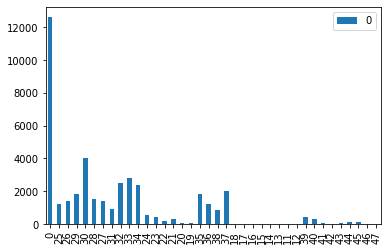

In [ ]:
a= []
y_scalar = np.array([np.where(r==1)[0][0] for r in y])

for i in range(0,70):
  a.append((y_scalar.tolist().count(i)))

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas
# print(max(y_scalar))
from collections import Counter
a =Counter(y_scalar)
df = pandas.DataFrame.from_dict(a, orient='index')
df.plot(kind='bar')
print(len(a))
# plt.ylabel('Number of train_data')
# plt.xlabel('Class');


### Build and train the Bayesian CNN model

In [ ]:
# def build_bayesian_bcnn_model(input_shape, train_size):
#     # print(train_size)
#     model_in = Input(shape=(1024,), name='input', dtype='float32')
#     a = Reshape(target_shape=(1024, 1, 1), name='input-reshape')(model_in)

#     conv_1 = Convolution2DFlipout(512, kernel_size=(3, 3), padding="same", strides=2,
#                                   kernel_divergence_fn=None)
#     conv_1 = add_kl_weight(conv_1, train_size)
#     x = conv_1(a)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     conv_2 = Convolution2DFlipout(128, kernel_size=(3, 3), padding="same", strides=2,
#                                   kernel_divergence_fn=None)
#     conv_2 = add_kl_weight(conv_2, train_size)
#     x = conv_2(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     conv_2 = Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2,
#                                   kernel_divergence_fn=None)
#     conv_2 = add_kl_weight(conv_2, train_size)
#     x = conv_2(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     conv_2 = Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2,
#                                   kernel_divergence_fn=None)
#     conv_2 = add_kl_weight(conv_2, train_size)
#     x = conv_2(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     # x = conv_2(x)
#     # x = BatchNormalization()(x)
#     # x = Activation('relu')(x)

#     x = Flatten()(x)
#     dense_1 = DenseFlipout(512, activation='relu',
#                            kernel_divergence_fn=None)
#     dense_1 = add_kl_weight(dense_1, train_size)
#     x = dense_1(x)
#     # x =dense_1(x)
#     dense_2 = DenseFlipout(70, activation=None,
#                            kernel_divergence_fn=None)
#     dense_2 = add_kl_weight(dense_2, train_size)
#     model_out = dense_2(x)  # logits
#     model = Model(model_in, model_out)
#     return model
    
# bcnn_model = build_bayesian_bcnn_model(X_train.shape[1:], n_train)
# bcnn_model.compile(loss=neg_log_likelihood_with_logits, optimizer=Adam(lr), metrics=['acc'],
#                    experimental_run_tf_function=False)
# bcnn_model.summary()       65 % accuracy
lr = 1e-3
from tensorflow.keras.layers import Input, Reshape, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, Dropout, Permute, Flatten, Dense
from tensorflow.keras.models import Model


def build_bayesian_bcnn_model(input_shape, train_size):
    # print(train_size)
    model_in = Input(shape=(1024,), name='input', dtype='float32')
    a = Reshape(target_shape=(1024, 1, 1), name='input-reshape')(model_in)

    conv_1 = Convolution2DFlipout(512, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_1 = add_kl_weight(conv_1, train_size)
    x = conv_1(a)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv_2 = Convolution2DFlipout(256, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_2 = add_kl_weight(conv_2, train_size)
    x = conv_2(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    conv_2 = Convolution2DFlipout(128, kernel_size=(3,3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_2 = add_kl_weight(conv_2, train_size)
    x = conv_2(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    conv_2 = Convolution2DFlipout(64, kernel_size=(3,3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_2 = add_kl_weight(conv_2, train_size)
    x = conv_2(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # conv_2 = Convolution2DFlipout(128, kernel_size=(2, 2), padding="same", strides=1,
    #                               kernel_divergence_fn=None)
    # conv_2 = add_kl_weight(conv_2, train_size)
    # x = conv_2(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)
    # x = conv_2(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)

    x = Flatten()(x)
    dense_1 = DenseFlipout(1024, activation='relu',
                           kernel_divergence_fn=None)
    dense_1 = add_kl_weight(dense_1, train_size)
    x = dense_1(x)
    # x =dense_1(x)
    dense_2 = DenseFlipout(70, activation=None,
                           kernel_divergence_fn=None)
    dense_2 = add_kl_weight(dense_2, train_size)
    model_out = dense_2(x)  # logits
    model = Model(model_in, model_out)
    return model
    
bcnn_model = build_bayesian_bcnn_model(X_train.shape[1:], X_train.shape[0])
bcnn_model.compile(loss=neg_log_likelihood_with_logits, optimizer=Adam(lr), metrics=['acc'],
                   experimental_run_tf_function=False)
bcnn_model.summary()    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024)]            0         
_________________________________________________________________
input-reshape (Reshape)      (None, 1024, 1, 1)        0         
_________________________________________________________________
conv2d_flipout_10 (Conv2DFli (None, 512, 1, 512)       9729      
_________________________________________________________________
batch_normalization_10 (Batc (None, 512, 1, 512)       2048      
_________________________________________________________________
activation_10 (Activation)   (None, 512, 1, 512)       0         
_________________________________________________________________
conv2d_flipout_11 (Conv2DFli (None, 256, 1, 256)       2359553   
_________________________________________________________________
batch_normalization_11 (Batc (None, 256, 1, 256)       1024

In [36]:
batch_size = 64
n_epochs = 10

hist = bcnn_model.fit(X_train, y_train, batch_size = batch_size, epochs = n_epochs, verbose = 1, validation_data = (X_test, y_test))


Epoch 1/10
518/518 [==============================] - 44s 84ms/step - loss: 15.7508 - acc: 0.6873 - val_loss: 14.5268 - val_acc: 0.6702
Epoch 2/10
518/518 [==============================] - 44s 84ms/step - loss: 13.2911 - acc: 0.6905 - val_loss: 12.3533 - val_acc: 0.6670
Epoch 3/10
518/518 [==============================] - 44s 84ms/step - loss: 11.3557 - acc: 0.6890 - val_loss: 10.6537 - val_acc: 0.6624
Epoch 4/10
518/518 [==============================] - 44s 84ms/step - loss: 9.8336 - acc: 0.6892 - val_loss: 9.2714 - val_acc: 0.6679
Epoch 5/10
518/518 [==============================] - 44s 84ms/step - loss: 8.6123 - acc: 0.6872 - val_loss: 8.1939 - val_acc: 0.6599
Epoch 6/10
518/518 [==============================] - 44s 84ms/step - loss: 7.6274 - acc: 0.6862 - val_loss: 7.3135 - val_acc: 0.6629
Epoch 7/10
518/518 [==============================] - 44s 84ms/step - loss: 6.8281 - acc: 0.6846 - val_loss: 6.5690 - val_acc: 0.6630
Epoch 8/10
518/518 [==============================] - 44

### Plot training process

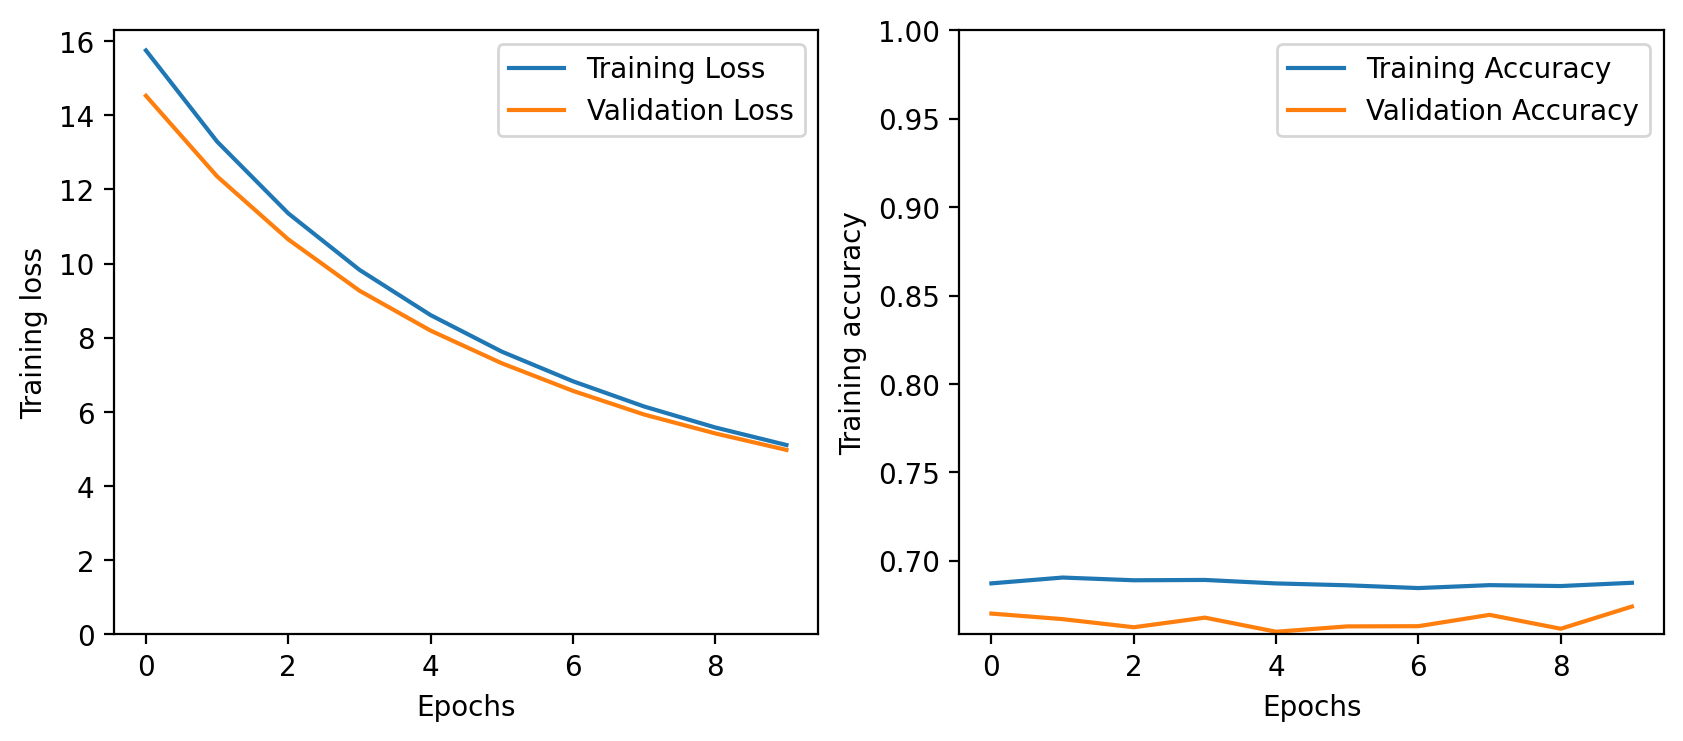

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

ax[0].plot(range(n_epochs), hist.history['loss'], label='Training Loss')
ax[0].plot(range(n_epochs), hist.history['val_loss'], label='Validation Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training loss')
ax[0].set_ylim([0, None])

ax[1].plot(range(n_epochs), hist.history['acc'], label='Training Accuracy')
ax[1].plot(range(n_epochs), hist.history['val_acc'], label="Validation Accuracy")
ax[1].legend()
ax[1].set_ylim([None, 1])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training accuracy')

plt.show()

### Quantify the uncertainty in predictions through sampling

In [38]:
n_mc_run = 100

y_pred_logits_list = np.array([bcnn_model.predict(X_test) for _ in range(n_mc_run)])  # a list of predicted logits

In [39]:
print(X_test.shape)
print(y_pred_logits_list.shape)

print('\ntest sample 0, label = 0, samples:\n', y_pred_logits_list[:10,0,0])
print('\ntest sample 0, label = 7, samples:\n', y_pred_logits_list[:10,0,7])

(8274, 1024)
(100, 8274, 70)

test sample 0, label = 0, samples:
 [3.7803035 4.74652   5.550943  4.7897606 4.9361777 4.898989  4.878084
 4.006336  4.5485754 4.3840256]

test sample 0, label = 7, samples:
 [-26.91579  -22.571968 -26.887413 -12.683284 -24.740494 -21.075056
 -26.042587 -27.24635  -19.962889 -12.910203]


In [40]:
med_prob_thres = 0.2 # probability threshold
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = np.array([np.array([int(np.median(y) >= med_prob_thres) for y in y_pred_prob]) for y_pred_prob in y_pred_prob_all])


In [41]:
idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

Number of recognizable samples: 8259
Unrecognizable samples: [ 690 2690 2807 3002 3855 3934 4401 4551 4790 5262 5623 7343 7853 8000
 8022]
Test accuracy on MNIST (recognizable samples): 0.6914880736166606
Test accuracy on MNIST (unrecognizable samples): 0.13333333333333333


### Define the function that plots the histogram of predicted probabilities across all possible classes

In [42]:
def plot_pred_hist(y_pred, n_class, n_mc_run, n_bins=30, med_prob_thres=0.2, n_subplot_rows=2, figsize=(20, 7)):
    print('\nmedian of predicted probs = \n', np.median(y_pred, axis=1))
    bins = np.logspace(-n_bins, 0, n_bins+1)
    n_subplot_cols = (n_class + 1) // n_subplot_rows
    fig, ax = plt.subplots(n_subplot_rows, n_subplot_cols, figsize=figsize, dpi=150)
    for i in range(n_subplot_rows):
        for j in range(n_subplot_cols):
            idx = i * n_subplot_cols + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median prob: {:.2f}) ({})".format(str(idx),
                                                                               np.median(y_pred[idx]),
                                                                               str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    fig.subplots_adjust(hspace=0.4)
    plt.show()

### A recognizable example

In [43]:
idx = 1
# plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
# plt.show()
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

True label of the test sample 1: 0


NameError: ignored

### An unrecognizable examples

In [ ]:
idx = 659
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
plt.show()
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

## Predict non-number images in Fashion-MNIST dataset

The model is trained to recongnize numbers with confidence. If asked to predict a non-number image, instead of randomly guessing, the model will not predict. Let's take images in Fashion-MNIST dataset as an example.

In [ ]:
print('Loading Fashion-MNIST dataset')
_, (X_f_test, y_f_test) = tf.keras.datasets.fashion_mnist.load_data()

X_f_test = np.expand_dims(X_f_test, -1)[:1000]
y_f_test = tf.keras.utils.to_categorical(y_f_test, n_class)[:1000]

print("X_f_test.shape =", X_f_test.shape)
print("y_f_test.shape =", y_f_test.shape)

### Quantify uncertainty

In [ ]:
n_mc_run = 100

y_f_pred_logits_list = np.array([bcnn_model.predict(X_f_test) for _ in range(n_mc_run)])  # a list of predicted logits

In [ ]:
print(X_f_test.shape)
print(y_f_pred_logits_list.shape)

print('\ntest sample 0, label = 0, samples:\n', y_f_pred_logits_list[:10,0,0])
print('\ntest sample 0, label = 7, samples:\n', y_f_pred_logits_list[:10,0,7])

In [ ]:
med_prob_thres = 0.2 # probability threshold
y_f_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_f_pred_logits_list], axis=-1)
y_f_pred = np.array([np.array([int(np.median(y) >= med_prob_thres) for y in y_f_pred_prob]) for y_f_pred_prob in y_f_pred_prob_all])


In [ ]:
idx_f_valid = [any(y) for y in y_f_pred]
print('Number of recognizable samples:', sum(idx_f_valid))
# print('Recognizable samples:', np.where(idx_f_valid)[0])

idx_f_invalid = [not any(y) for y in y_f_pred]
print('Number of unrecognizable samples:', sum(idx_f_invalid))
print('\n10 unrecognizable samples:', np.where(idx_f_invalid)[0][:10])

print('\nTest accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_f_test[idx_f_valid], axis=-1), np.argmax(y_f_pred[idx_f_valid], axis=-1))) / len(y_f_test[idx_f_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_f_test[idx_f_invalid], axis=-1), np.argmax(y_f_pred[idx_f_invalid], axis=-1))) / len(y_f_test[idx_f_invalid]))



### An  unrecognizable example

In [ ]:
idx = 6
plt.imshow(X_f_test[idx, :, :, 0], cmap='gist_gray')
plt.show()
print("True label of the test sample {}: {}".format(idx, np.argmax(y_f_test[idx], axis=-1)))

plot_pred_hist(y_f_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_f_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")